# Ramp sequence

The first one isn't working, and not sure why. Trying a differetnt method, doing a single pulse and continuously reading over it to see decay (or no decay with ramp).

In [1647]:
%matplotlib inline
import local_broom

In [1648]:
from zhinst.toolkit import Session, CommandTable, Sequence, Waveforms, SHFQAChannelMode

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import time
from monty import Monty

## Connect

In [1649]:
# connect to instruments

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

# connect to data server
session = Session(SERVER_HOST)

# connect to device
device = session.connect_device(DEVICE_ID)

In [1650]:
#session.disconnect_device(DEVICE_ID)

In [1651]:
experiment = {
    "desc": "Measure AC decay."
}

monty = Monty("rf.decay", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 119


## Variables

In [1652]:
# gate sampling time
samplingDivider = 6

# setup averaging. It is faster to run averages on the device but no feedback can take place
averages = 1  # python averages
seq_averages = 10000  # seqc averages

# readout signals
readout_gain = 0.95  # If we set this to 1, then output overloads
readout_freq = 406.2e6  # (Hz)

# drive line amplitudes (maximum 340mV, give in terms of V)
p1_amp = 0.05

# AC decay ramp rate
ramp_rate = 13e-5  # V/sample

# powers
input_pwr = -0
output_pwr = -0
dr_pwr = 0

# timings in seconds
prior_time = 100e-6  # A time
pulse_time = 0.8e-3
after_time = 100e-6
read_time = 20e-6  # integration time, want to keep this short in order to increase the number of points
trigger_time = 6e-3  # internal trigger holdoff time (metronome)
measure_delay = 10*read_time  # initial delay for measurement after sending the pulse

# internal
read_lens = int((pulse_time-measure_delay) / read_time)
offset = 0  # makes sure we don't read past the end of the pulse


In [1653]:
# check we can fit all the points into memory
MAX_MEASUREMENTS = 2**19
if seq_averages*(read_lens-offset) > MAX_MEASUREMENTS:
    raise OverflowError("Requested too many points to be measured. (Use around 500,000 points)")

In [1654]:
params = {
    "samplingDivider": samplingDivider,
    "averages": averages,
    "seq_averages": seq_averages,
    "readout_gain": readout_gain,
    "readout_freq": readout_freq,
    "p1_amp": p1_amp,
    "ramp_rate": ramp_rate,
    
    "input_pwr": input_pwr,
    "output_pwr": output_pwr,
    "dr_pwr": dr_pwr,
    
    "prior_time": prior_time,
    "pulse_time": pulse_time,
    "after_time": after_time,
    "read_time": read_time,
    "trigger_time": trigger_time,
    "measure_delay": measure_delay,
    "read_lens": read_lens,
    "offset": offset,
}

## Functions

In [1655]:
def timeToSamples(time, samplingRateDivider):
    # returns the number of samples divisible by 16 given a time (in seconds) and sampling rate divider
    samples_raw = time * (1/(2**samplingRateDivider))/0.5e-9
    samples_modulo = int(samples_raw) % 16
    samples = int(samples_raw) - int(samples_modulo)
    return samples

# custom curve fit
amps = [1, 0.85, 0.75, 0.65,  0.5, 0.35, 0.25, 0.2, 0.125, 0.05]
voltages = [0.34, 0.268, 0.207, 0.158, 0.094, 0.0481,  0.026, 0.0183, 0.01, 0.0057]

alt_fit = np.poly1d(np.polyfit(amps, voltages, 2))
# Hard coding alt_fit values in case something goes horribly wrong

def voltToDbm(volt, dbmrange):
    # Ok yes this can be better, deal with it
    if dbmrange != 0:
        raise Exception("This function only works with a dBm range of 0.")
    
    if volt > 0.34 or volt < -0.34:
        raise ValueError(f"Given voltage ({volt} V) is greater than max output of SHFQC (0.34 V)")
    
    if volt < 0:
        amplitude = 1/300*(np.sqrt(3e5*-volt + 529) - 23)
        return -amplitude
    else:
        amplitude = 1/300*(np.sqrt(3e5*volt + 529) - 23)
        return amplitude


def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1:  # readout 1 point
                wave_data_captured[node] = True
                # total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

def cmdtable(ct, amplitude, length, wave_index, ct_index):
    """
    Load a default command table with a sin/cos wave (used throughout the documentation)
    """
    ct.table[ct_index].waveform.index = wave_index
    ct.table[ct_index].amplitude00.value = amplitude  # all in dBm
    ct.table[ct_index].amplitude01.value = -amplitude
    ct.table[ct_index].amplitude10.value = amplitude
    ct.table[ct_index].amplitude11.value = amplitude
    ct.table[ct_index].waveform.length = length  # in samples
    ct.table[ct_index].waveform.samplingRateDivider = samplingDivider  # inherit global

## Channel Setup

In [1656]:
# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "ST": device.sgchannels[0],
    "P1": device.sgchannels[1],  # drive P1 line
    "P2": device.sgchannels[2],  # drive P2 line
}

drive_chans = ["P1"]  # match keys above

In [1657]:
with device.set_transaction():
    # setup drive channels
    for c in drive_chans:
        chan[c].output.range(dr_pwr)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
        chan[c].output.on(1)  # enable output
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        chan[c].marker.source(0)  # setup the AWG trigger 1 (is this an input trigger option? doesn't seem necessary)
        # see manual page p235 for all trigger options
        chan[c].awg.auxtriggers[0].channel(8)  # 8=use internal trigger, 1024=use software trigger

    # setup measure channel
    
    chan["measure"].output.rflfpath(0)  # use LF mode not RF (for signals under 600Mhz)
    chan["measure"].input.rflfpath(0)
    chan["measure"].oscs[0].freq(readout_freq)  # CW frequency (in LF mode)
    chan["measure"].oscs[0].gain(readout_gain)  # If we set this to 1, then output overloads

    # configure these based on how the sweeper works internally
    # See https://docs.zhinst.com/zhinst-utils/en/latest/_modules/zhinst/utils/shf_sweeper.html#ShfSweeper
    chan["measure"].spectroscopy.delay(0)  # integration delay in units of second
    chan["measure"].spectroscopy.length(timeToSamples(read_time, samplingDivider))  # integration time length in units of number of samples (usually integration_time*sampling_rate)
    # setup when the spectroscopy is triggered
    chan["measure"].spectroscopy.trigger.channel("chan0seqtrig0")  # make sure to use the trigger coming from the sequencer code
    # setup result parameters
    chan["measure"].spectroscopy.result.averages(1)  # number of averages (always average in software not hardware)
    chan["measure"].spectroscopy.result.length(seq_averages*(read_lens-offset))  # number of results
    chan["measure"].spectroscopy.result.enable(0)  # disable result logger

    chan["measure"].configure_channel(
        center_frequency=0,  # in units of Hz  # minimum of 600MHz for RF mode
        input_range=input_pwr,  # in units of dBm
        output_range=output_pwr,  # in units of dBm
        mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
    )
    
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)

    chan["measure"].generator.auxtriggers[1].channel("inttrig")  # i believe this is overwritten by the following line
    chan["measure"].generator.configure_sequencer_triggering(
        aux_trigger=8,  # alternatively use 8=internal trigger, or "software_trigger0" to use the software triggering system
        play_pulse_delay=0
    )


## Sequence

In [1658]:
samples = timeToSamples(pulse_time, samplingDivider)
wv = np.linspace(voltToDbm(p1_amp, dr_pwr), voltToDbm(p1_amp+p1_amp*samples*ramp_rate, dr_pwr), samples)

In [1659]:
# use the same waveforms for all sequence programs
p1_prog_code = f"""

// Assign a single channel waveform to wave table entry 0
// wave w_a = ones({timeToSamples(pulse_time, samplingDivider)});

// Reset the oscillator phase
// resetOscPhase();

repeat({seq_averages}) {{
        waitDigTrigger(1);

        setTrigger(1);  // Trigger the scope
        setTrigger(0);

        playZero({timeToSamples(prior_time, samplingDivider)-32}, {samplingDivider});
        playZero(32, {samplingDivider});
        executeTableEntry(0);
}}
"""

readout_prog_code = f"""
setTrigger(0); // Set low as this starts the spectroscopy readout....

repeat({seq_averages}) {{
    waitDigTrigger(1);
    playZero(224); // lineup with SG trigger (224 samples = lines up with SG trigger);
    playZero({timeToSamples(prior_time, samplingDivider)}, {samplingDivider});
    playZero({timeToSamples(measure_delay, samplingDivider)-32}, {samplingDivider}); // a little buffer time
    playZero(32, {samplingDivider});
    
    for (var i = 0; i < {read_lens-offset}; i++) {{
    
        setTrigger(1);  // trigger the output. As this matches "chan0seqtrig0" the spectroscopy is started
        setTrigger(0);
        playZero({timeToSamples(read_time, samplingDivider)-32}, {samplingDivider});
        playZero(32, {samplingDivider});
    }}
}}
"""


In [1660]:
# upload waveforms to instrument

# upload drive code
for channel in [chan["P1"]]:
    seq = Sequence()
    seq.code = p1_prog_code
    seq.waveforms = Waveforms()
    seq.waveforms[0] = wv

    channel.awg.load_sequencer_program(seq)
    channel.awg.write_to_waveform_memory(seq.waveforms)

    print(f"_________ {channel} _________")
    print(seq.code)
    
# upload with sequence code as the memory must be allocated first

# upload measure code
print("_________  READOUT  _________")
print(readout_prog_code)
print(chan["measure"].generator.load_sequencer_program(readout_prog_code))

_________ /dev12158/sgchannels/1 _________


// Assign a single channel waveform to wave table entry 0
// wave w_a = ones(24992);

// Reset the oscillator phase
// resetOscPhase();

repeat(10000) {
        waitDigTrigger(1);

        setTrigger(1);  // Trigger the scope
        setTrigger(0);

        playZero(3088, 6);
        playZero(32, 6);
        executeTableEntry(0);
}

_________  READOUT  _________

setTrigger(0); // Set low as this starts the spectroscopy readout....

repeat(10000) {
    waitDigTrigger(1);
    playZero(224); // lineup with SG trigger (224 samples = lines up with SG trigger);
    playZero(3120, 6);
    playZero(6208, 6); // a little buffer time
    playZero(32, 6);
    
    for (var i = 0; i < 30; i++) {
    
        setTrigger(1);  // trigger the output. As this matches "chan0seqtrig0" the spectroscopy is started
        setTrigger(0);
        playZero(592, 6);
        playZero(32, 6);
    }
}

{'messages': '', 'maxelfsize': 2147483648}


In [1661]:
loaded_waveforms = chan["P1"].awg.read_from_waveform_memory()

loaded_waveforms.validate(chan["P1"].awg.waveform.descriptors())

## Command Tables

In [1662]:
# each pulse needs its own command table
for channel in [chan["P1"]]:
    schema = channel.awg.commandtable.load_validation_schema()
    ct = CommandTable(schema)

    #ct.active_valitation = True
    for wave_index in range(1):
        cmdtable(ct,
                 amplitude= voltToDbm(p1_amp, channel.output.range()),
                 length=timeToSamples(pulse_time, samplingDivider),
                 wave_index=wave_index,
                 ct_index=wave_index,
                )
    channel.awg.commandtable.upload_to_device(ct)

## Run

In [1663]:
device.system.internaltrigger.repetitions(seq_averages)  # make sure that this matches how many pulses we are sending
device.system.internaltrigger.holdoff(trigger_time)  # init_len + 2*wait_and_settle + 100e-6*2)  # how long to wait between retriggers (increments of 100ns)

In [1664]:
# setup channel synchronization
chan["measure"].synchronization.enable(1)
chan["P1"].synchronization.enable(1)
chan["ST"].synchronization.enable(0)
device.system.internaltrigger.synchronization.enable(1)

Started new run p1_decay.119


  0%|          | 0/100 [00:00<?, ?it/s]

Sequencers in unknown state. Perhaps they are not synchronised? 0, 0
300000
Run finished and took 0:01:02.501465.
Saving to p1_decay.119.xz
Saving to experiment.yaml


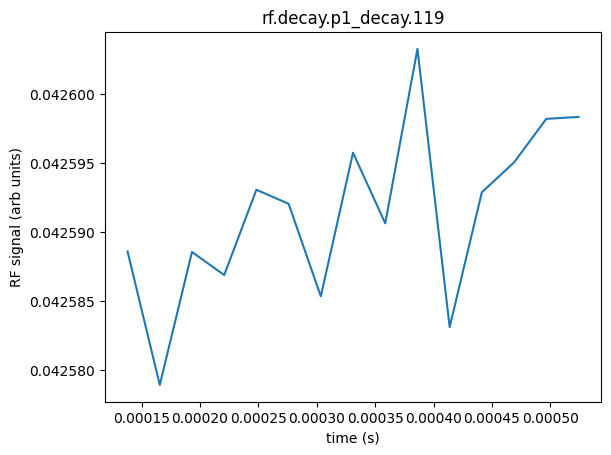

In [1665]:
data = []

monty.newrun("p1 decay", params)

device.system.internaltrigger.enable(0)

result_node = chan["measure"].spectroscopy.result.data.wave
result_node.subscribe()

chan["measure"].spectroscopy.result.enable(1)  # start logger

# start sequencers
chan["measure"].generator.enable_sequencer(single=True)
chan["P1"].awg.enable_sequencer(single=True)  # dont want to repeat

# start triggering sequence (which starts each sequencer)
device.system.internaltrigger.enable(1)
time.sleep(0.1)

# wait for the measurement to complete
tic = time.time()
pbar = tqdm(total=100)
while device.system.internaltrigger.progress() != 1.0:
    p = int(device.system.internaltrigger.progress()*100)
    pbar.update(p-pbar.n)
    time.sleep(0.001)
pbar.update(100-pbar.n)
pbar.close()
#print(time.time()-tic)

# time.sleep(0.1)
m_state = chan["measure"].generator.sequencer.status()
st_state = chan["P1"].awg.sequencer.status()
if m_state != 4 and st_state != 4:
    print(TimeoutError(f"Sequencers in unknown state. Perhaps they are not synchronised? {m_state}, {st_state}"))
    time.sleep(0.5)

# chan["measure"].spectroscopy.result.enable(0)  # stop data logger

#device.system.internaltrigger.enable(0)

# wait for completion
while chan["measure"].spectroscopy.result.enable() != 0:
    print(chan["measure"].spectroscopy.result.enable())
    chan["measure"].spectroscopy.result.enable.wait_for_state_change(0, timeout=10)
    time.sleep(0.01)


# get results
results = get_results(result_node, timeout=5)
result_node.unsubscribe()

# verify results
acq = chan["measure"].spectroscopy.result.acquired()
if len(results) > acq:
    print(chan["measure"].generator.ready())
    print(chan["P1"].awg.ready())
    print(bin(chan["measure"].generator.sequencer.status()))
    print(bin(chan["P1"].awg.sequencer.status()))

    # Status of the Sequencer on the instrument.
    # Bit 0: Sequencer is running;
    # Bit 1: reserved;
    # Bit 2: Sequencer is waiting for a trigger to arrive;
    # Bit 3: Sequencer has detected an error;
    # Bit 4: sequencer is waiting for synchronization with other channels
    raise TimeoutError(f"Not all datapoints measured in the time provided. {acq} of {len(results)}.")

print(len(results))

data = np.mean(results.reshape((seq_averages, (read_lens-offset))), axis=0)

time.sleep(1)
chan["measure"].input.on(0)
chan["measure"].output.on(0)

plt.plot(np.linspace(0, pulse_time, read_lens)[5:read_lens - offset - 10], np.abs(data)[5:read_lens - offset - 10])  # picking up the first and last bits, so trimming those
plt.xlabel("time (s)")
plt.ylabel("RF signal (arb units)")
plt.title(monty.identifier + "." + monty.runname)

monty.save({"data": data})
monty.savefig(plt, "ramp decay")

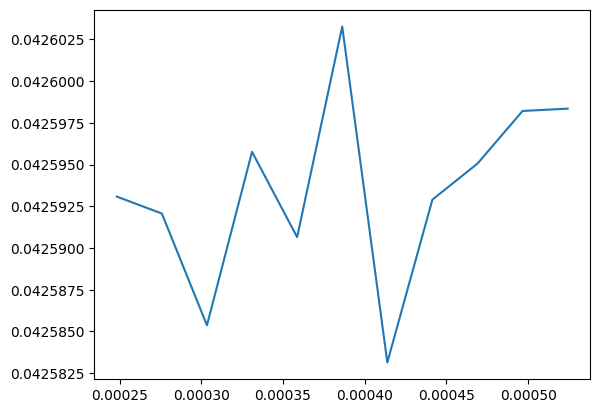

In [1666]:
plt.plot(np.linspace(0, pulse_time, read_lens)[9:read_lens - 10], np.abs(data)[9:read_lens - 10])

In [1667]:
1/400e6

2.5e-09

In [1668]:
timeToSamples(20e-6, 6)

624

In [1669]:
timeToSamples(19.9e-6, 6)

608

In [1670]:
read_lens-offset

30

In [1671]:
read_lens

30

In [1672]:
read_lens = pulse_time / read_time
read_lens

40.0

In [1673]:
read_time

2e-05

In [1674]:
524288

524288

In [1675]:
2**19

524288

In [1676]:
100000*30 - 2**19

2475712